# Underfitting, overfitting, regularization, dropout

## Load and minibatch MNIST data

In [1]:
using Knet, Plots, Images

In [2]:
include(Knet.dir("data","mnist.jl"))
xtrn,ytrn,xtst,ytst = mnist()
Atype = gpu() >= 0 ? KnetArray{Float32} : Array{Float32}
dtst = minibatch(xtst,ytst,100;xtype=Atype) # [ (x1,y1), (x2,y2), ... ] where xi,yi are minibatches of 100
dtrn = minibatch(xtrn,ytrn,100;xtype=Atype) # [ (x1,y1), (x2,y2), ... ] where xi,yi are minibatches of 100
length(dtrn),length(dtst)

INFO: Loading MNIST...


(600, 100)

In [3]:
(x,y)=first(dtst)
println(summary(x))
println(summary(y))

28×28×1×100 Knet.KnetArray{Float32,4}
100-element Array{UInt8,1}


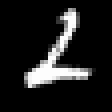

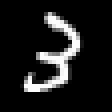

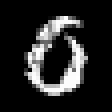

3-element Array{UInt8,1}:
 0x02
 0x03
 0x0a

In [4]:
rp = randperm(10000)
for i=1:3; display(mnistview(xtst,rp[i])); end
display(ytst[rp[1:3]])

## Define linear model

In [8]:
function linear(w,x)
    y = w[1]*mat(x) .+ w[2]
end

winit1()=map(Atype, [ 0.1*randn(10,784), zeros(10,1) ])

winit1 (generic function with 1 method)

In [10]:
srand(9)
w = winit1();  # random weight matrix and a zero bias vector

In [11]:
ypred=linear(w,x)
display(ypred)

10×100 Knet.KnetArray{Float32,2}:
  0.20949      0.204775   -0.932485   -0.97682     0.694272  …  -0.332532  -0.510457   -1.40151    -0.76995    -0.152675
  0.455851    -0.707735   -0.22817    -0.0821219   1.12012       0.259282  -0.132053   -0.523914    0.0569146   0.522016
 -0.00504193  -2.14745     0.0253635  -1.09536    -1.06499       1.02387   -0.0384934  -0.288532   -0.825279   -1.07451 
  1.32813     -1.03565     0.237599    0.136671    0.455203      0.508845  -0.0922899   0.607264    0.487591   -0.231088
  0.351397    -0.638922   -1.09847    -0.554185   -0.654054     -0.296868  -0.580158    0.316118   -0.460735   -1.00915 
 -0.180563    -0.725433   -0.8814     -0.572751   -0.506427  …  -1.66223    0.277045   -1.90686     0.0757486  -1.3144  
  0.370442     0.0319697  -0.865752   -0.644942    0.797276     -0.762742  -0.698524   -1.2362      0.79252     0.637139
 -0.105419     0.478139    0.305943    0.828578    0.245938      0.900937   0.494892    0.516854    1.07525     1.38668

In [12]:
display(y)

100-element Array{UInt8,1}:
 0x07
 0x02
 0x01
 0x0a
 0x04
 0x01
 0x04
 0x09
 0x05
 0x09
 0x0a
 0x06
 0x09
    ⋮
 0x06
 0x01
 0x03
 0x06
 0x09
 0x03
 0x01
 0x04
 0x01
 0x07
 0x06
 0x09

## Measuring error rate

In [13]:
accuracy(w,dtst,linear)

0.0971

## Measuring loss

In [14]:
# Calculate cross entropy loss of a model with weights w for one minibatch (x,p)
# Use non-zero l1 or l2 for regularization
function softloss(w,x,p,model;l1=0,l2=0,o...)  
    y = model(w,x;o...)
    J = nll(y,p)
    if l1 != 0; J += l1 * sum(sum(abs,wi)  for wi in w[1:2:end]); end
    if l2 != 0; J += l2 * sum(sum(abs2,wi) for wi in w[1:2:end]); end
    return J
end

softloss (generic function with 1 method)

In [18]:
nll(linear(w,x),y)  # per-instance average softloss for the first test minibatch

2.8222036f0

In [19]:
nll(w,dtst,linear)  # per-instance average softloss for the whole test set

2.8204281f0

## Manually defined gradient for softloss

In [ ]:
#= TODO
function grad1(w,x,p,model)
    y = model(w,x)
    y = y .- maximum(y,1) # for numerical stability
    expy = exp.(y)
    q = expy ./ sum(expy,1)
    dJdy = (q - p) / size(x,2)
    dJdw = dJdy * x'
    dJdb = sum(dJdy,2)
    Any[dJdw,dJdb]
end
=#

## Automatically defined gradient for softloss

In [20]:
softgrad = grad(softloss)  # Knet/AutoGrad makes life easier :)

(::gradfun) (generic function with 1 method)

In [22]:
#TODO g1 = grad1(w,x,y,linear)

In [23]:
g2 = softgrad(w,x,y,linear)

2-element Array{Any,1}:
 Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x00000081051ff400, 31360, 0, nothing), (10, 784))
 Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x000000810530ea00, 40, 0, nothing), (10, 1))     

In [ ]:
#TODO isapprox(g1[1],g2[1])

In [24]:
#TODO isapprox(g1[2],g2[2])

## Checking the gradient

In [25]:
display(g2[2])  
# Meaning of gradient:
# If I move the last entry of w[2] by epsilon, loss will go up by 0.345075 epsilon!

10×1 Knet.KnetArray{Float32,2}:
 -0.0921663 
 -0.00683322
 -0.0612594 
 -0.0592853 
 -0.0203152 
 -0.0529135 
 -0.0752202 
  0.0736465 
 -0.0507283 
  0.345075  

In [26]:
display(w[2])

10×1 Knet.KnetArray{Float32,2}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [27]:
softloss(w,x,y,linear)

2.8222036f0

In [28]:
w[2][10] += 0.1   # to numerically check the gradient let's move the last entry by +0.1.

0.1

In [29]:
softloss(w,x,y,linear)  
# We see that the loss moves by +0.03 as expected.
# You should check all/most entries in your gradients this way to make sure they are correct.

2.8577392f0

## Training loop (SGD)

In [30]:
# Train model(w) with SGD and return a list containing w for every epoch
function train(w,data,model; epochs=100,lr=0.5,o...)
    weights = Any[copy(w)]
    for epoch in 1:epochs
        for (x,y) in data
            g = softgrad(w,x,y,model;o...)
            for i in 1:length(w)
                w[i] = w[i] - lr * g[i]
            end
        end
        push!(weights,copy(w))
    end
    return weights
end

train (generic function with 1 method)

## Training the linear model

In [31]:
srand(1)
@time trn1=train(winit1(),dtrn,linear)
@time trnloss1 = [ nll(w,dtrn,linear) for w in trn1 ]
@time tstloss1 = [ nll(w,dtst,linear) for w in trn1 ]
@time trnerr1 = [ 1-accuracy(w,dtrn,linear) for w in trn1 ]
@time tsterr1 = [ 1-accuracy(w,dtst,linear) for w in trn1 ]
minimum(tstloss1),minimum(tsterr1)

 25.327196 seconds (24.66 M allocations: 18.528 GiB, 4.35% gc time)
 17.146108 seconds (8.32 M allocations: 18.025 GiB, 5.21% gc time)
  2.864833 seconds (1.39 M allocations: 3.005 GiB, 5.29% gc time)
 18.549852 seconds (5.77 M allocations: 18.568 GiB, 4.68% gc time)
  3.243446 seconds (967.86 k allocations: 3.095 GiB, 4.51% gc time)


(0.29008842f0, 0.08150000000000002)

In [ ]:
length(trn1)

## Overfitting and underfitting

In [ ]:
plot([trnloss1 tstloss1],ylim=(.2,.36),labels=[:trnloss :tstloss],xlabel="Epochs",ylabel="Loss") 
# Demonstrates both overfitting and underfitting
# Overfitting: test loss is higher than training loss and getting worse
# Underfitting: training loss not close to 0

In [ ]:
plot([trnerr1 tsterr1],ylim=(.06,.10),labels=[:trnerr :tsterr],xlabel="Epochs",ylabel="Error")  
# this is the error plot, we get to about 8% error, i.e. 92% accuracy

## Linear model with L2 regularization

In [ ]:
# Let us try L2 regularization to address overfitting
srand(1)
@time trn2=train(winit1(),dtrn,linear;l2=0.00004)
@time trnloss2 = [avgloss(w,dtrn,linear) for w in trn2]
@time tstloss2 = [avgloss(w,dtst,linear) for w in trn2]
@time trnerr2 = [zeroone(w,dtrn,linear) for w in trn2]
@time tsterr2 = [zeroone(w,dtst,linear) for w in trn2]
minimum(tstloss2)

In [ ]:
plot([trnloss1 tstloss1 trnloss2 tstloss2],ylim=(0.2,0.36),
    labels=[:trnloss :tstloss :trnlossL2 :tstlossL2],xlabel="Epochs",ylabel="Loss") 
# overfitting less but results do not improve much

In [ ]:
plot([trnerr1 tsterr1 trnerr2 tsterr2],ylim=(0.06,0.10),
    labels=[:trnerr :tsterr :trnerrL2 :tsterrL2],xlabel="Epochs",ylabel="Error")

## Multi-layer Perceptron

In [ ]:
# Using a model with higher capacity helps underfitting
function mlp(w,x)
    for i=1:2:length(w)-2
        x = relu.(w[i]*x .+ w[i+1])
    end
    return w[end-1]*x .+ w[end]
end

In [ ]:
function winit(h...; std=0.01, x=784, y=10,  # use winit(h1,h2,...,hn) for n hidden layer mlp
               atype=gpu()>=0 ? KnetArray{Float32} : Array{Float32})
    h = [x, h..., y]
    w = Any[]
    for i=1:length(h)-1
        push!(w, std*randn(h[i+1],h[i]))
        push!(w, zeros(h[i+1],1))
    end
    map(atype, w)
end

In [ ]:
w2=winit(64) # gives weights and biases for an MLP with a single hidden layer of size 64

In [ ]:
softloss(w2,x,y,mlp)

In [ ]:
srand(1)
@time trn3=train(winit(64),dtrn,mlp)
@time trnloss3 = [ avgloss(w,dtrn,mlp) for w in trn3 ]
@time tstloss3 = [ avgloss(w,dtst,mlp) for w in trn3 ]
@time trnerr3 = [ zeroone(w,dtrn,mlp) for w in trn3 ]
@time tsterr3 = [ zeroone(w,dtst,mlp) for w in trn3 ]
minimum(tstloss3)

In [ ]:
plot([trnloss1 tstloss1 trnloss3 tstloss3],ylim=(0.0,0.4),
    labels=[:trnLin :tstLin :trnMLP :tstMLP],xlabel="Epochs",ylabel="Loss")  
# solves the underfitting problem!

In [ ]:
plot([trnerr1 tsterr1 trnerr3 tsterr3],ylim=(0,0.1),
    labels=[:trnLin :tstLin :trnMLP :tstMLP],xlabel="Epochs",ylabel="Error")  
# error improves from 8% to 2%!

## MLP with L1 regularization

In [ ]:
# We still have overfitting, let's try L1 regularization and a lower learning rate
srand(1)
@time trn4=train(winit(64),dtrn,mlp;lr=0.1,l1=4e-5)
@time trnloss4 = [ avgloss(w,dtrn,mlp) for w in trn4 ]
@time tstloss4 = [ avgloss(w,dtst,mlp) for w in trn4 ]
@time trnerr4 = [ zeroone(w,dtrn,mlp) for w in trn4 ]
@time tsterr4 = [ zeroone(w,dtst,mlp) for w in trn4 ]
minimum(tstloss4)

In [ ]:
plot([trnloss3 tstloss3 trnloss4 tstloss4],ylim=(0,0.15),
    labels=[:trnMLP :tstMLP :trnMLP_L1 :tstMLP_L1],xlabel="Epochs", ylabel="Loss")  
# overfitting less, loss results improve

In [ ]:
plot([trnerr3 tsterr3 trnerr4 tsterr4],ylim=(0,0.04),
    labels=[:trnMLP :tstMLP :trnMLP_L1 :tstMLP_L1],xlabel="Epochs", ylabel="Error")    
# however error results do not improve! 

In [ ]:
minimum(tsterr3),minimum(tsterr4)

## MLP with dropout

In [ ]:
# Dropout is another way to address overfitting
function dropout(x,p)
    if p > 0
        x .* (rand!(similar(x)) .> p) ./ (1-p)
    else
        x
    end
end

function mlp(w,x; pdrop=(0,0))
    x = dropout(x,pdrop[1])
    for i=1:2:length(w)-2
        x = relu.(w[i]*x .+ w[i+1])
        x = dropout(x,pdrop[2])
    end
    return w[end-1]*x .+ w[end]
end

In [ ]:
srand(1)
@time trn5=train(winit(64),dtrn,mlp;lr=0.1,pdrop=(0.2,0))
@time trnloss5 = [ avgloss(w,dtrn,mlp) for w in trn5 ]
@time tstloss5 = [ avgloss(w,dtst,mlp) for w in trn5 ]
@time trnerr5 = [ zeroone(w,dtrn,mlp) for w in trn5 ]
@time tsterr5 = [ zeroone(w,dtst,mlp) for w in trn5 ]
minimum(tstloss5),minimum(tsterr5)

In [ ]:
plot([trnloss3 tstloss3 trnloss5 tstloss5],ylim=(0,0.15),
    labels=[:trnMLP :tstMLP :trnDropout :tstDropout],xlabel="Epochs", ylabel="Loss")  
# overfitting less, loss results improve

In [ ]:
plot([trnerr3 tsterr3 trnerr5 tsterr5],ylim=(0,0.04),
    labels=[:trnMLP :tstMLP :trnDropout :tstDropout],xlabel="Epochs", ylabel="Error")  
# this time error also improves slightly

In [ ]:
minimum(tsterr3),minimum(tsterr4),minimum(tsterr5)

In [ ]:
minimum(tstloss3),minimum(tstloss4),minimum(tstloss5)

## MLP with larger hidden layer

In [ ]:
# The current trend is to use models with higher capacity tempered with dropout
srand(1)
@time trn6=train(winit(256),dtrn,mlp;lr=0.1,pdrop=(0.2,0))
@time trnloss6 = [ avgloss(w,dtrn,mlp) for w in trn6 ]
@time tstloss6 = [ avgloss(w,dtst,mlp) for w in trn6 ]
@time trnerr6 = [ zeroone(w,dtrn,mlp) for w in trn6 ]
@time tsterr6 = [ zeroone(w,dtst,mlp) for w in trn6 ]
minimum(tstloss6),minimum(tsterr6)

In [ ]:
plot([trnloss5 tstloss5 trnloss6 tstloss6],ylim=(0,0.15),
    labels=[:trn64 :tst64 :trn256 :tst256],xlabel="Epochs",ylabel="Loss")

In [ ]:
plot([trnerr5 tsterr5 trnerr6 tsterr6],ylim=(0,0.04),
    labels=[:trn64 :tst64 :trn256 :tst256],xlabel="Epochs",ylabel="Error")
# We are down to 0.015 error.